<h1 align=center>Paralelizando o treinamento de rede neural com o TensorFlow</h1>
<p align=center><img src=https://www.tensorflow.org/images/tf_logo_social.png?hl=pt-br width=500></p>

O *TensorFlow* é uma das bibliotecas de aprendizado profundo mais populares atualmente disponíveis e nos permite implementar redes neurais (RN) com muito mais eficiência do que qualquer uma de nossas implementações NumPy anteriores. Agora, começaremos a usar o *TensorFlow* e veremos como ele traz benefícios significativos para o desempenho do treinamento.

### *TensorFlow* e desempenho de treinamento
O *TensorFlow* pode acelerar significativamente nossas tarefas de aprendizado de máquina. Para entender como ele pode fazer isso, vamos começar discutindo alguns dos desafios de desempenho que normalmente encontramos quando executamos cálculos caros em nosso hardware. Em seguida, analisaremos em alto nível o que é o *TensorFlow* e qual será nossa abordagem de aprendizado.

### Como aprenderemos o *TensorFlow*
Primeiro, abordaremos o modelo de programação do *TensorFlow*, em particular, a criação e manipulação de tensores. Em seguida, veremos como carregar dados e utilizar objetos *TensorFlow* Dataset, o que nos permitirá iterar por meio de um conjunto de dados de forma eficiente. Além disso, discutiremos os conjuntos de dados existentes e prontos para uso no submódulo `tensorflow_datasets` e aprenderemos como usá-los.

Depois de aprender sobre esses conceitos básicos, a API `tf.keras` será introduzida e avançaremos para a construção de modelos de aprendizado de máquina, aprenderemos a compilar e treinar os modelos e aprenderemos a salvar os modelos treinados em disco para avaliação futura.

### Primeiros passos com o *TensorFlow* 

Vamos dar os primeiros passos no uso da API *TensorFlow* de baixo nível. Depois de instalar o *TensorFlow*, abordaremos como criar tensores no *TensorFlow* e diferentes maneiras de manipulá-los, como alterar sua forma, tipo de dados e assim por diante.

### Instalando o *TensorFlow*
Dependendo de como seu sistema está configurado, normalmente você pode usar o instalador `pip` do *Python* e instalar o *TensorFlow* do *PyPI* executando o seguinte no seu terminal:

`pip install tensorflow`

Isso instalará a versão estável mais recente. Para garantir que o código apresentado neste capítulo possa ser executado conforme o esperado, é recomendável usar o *TensorFlow* 2.0.0, que pode ser instalado especificando a versão explicitamente:

`pip install tensorflow==[versão desejada]`

### Criando tensores no *TensorFlow*
Agora, vamos considerar algumas maneiras diferentes de criar tensores e, em seguida, ver algumas de suas propriedades e como manipulá-las. Em primeiro lugar, podemos simplesmente criar um tensor de uma lista ou um array *NumPy* usando a função `tf.convert_to_tensor` da seguinte forma:

In [78]:
import tensorflow as tf
import numpy as np

tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

np.set_printoptions(precision=3)

a = np.array([1,2,3], dtype=np.int32)
b = [4,5,6]

t_a = tf.convert_to_tensor(a)
t_b = tf.convert_to_tensor(b)

print(t_a)
print(t_b)


tf.Tensor([1 2 3], shape=(3,), dtype=int32)
tf.Tensor([4 5 6], shape=(3,), dtype=int32)


Isso resultou nos tensores $\small t_a$ e $\small t_b$, com suas propriedades, `shape=(3,)` e `dtype=int32`, adotadas de sua fonte. Semelhante aos *arrays* *NumPy*, podemos ver ainda mais estas propriedades:

In [79]:
t_ones = tf.ones((2,3))
t_ones.shape

TensorShape([2, 3])

Para obter acesso aos valores aos quais um tensor se refere, podemos simplesmente chamar o método `.numpy()` em um tensor:

In [80]:
t_ones.numpy()

array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

Finalmente, a criação de um tensor de valores constantes pode ser feita da seguinte forma:

In [81]:
const_tensor = tf.constant([1.2,5, np.pi], dtype=tf.float32)

print(const_tensor)

tf.Tensor([1.2   5.    3.142], shape=(3,), dtype=float32)


### Manipulando o tipo de dados e a forma de um tensor
Aprender maneiras de manipular tensores é necessário para torná-los compatíveis para entrada em um modelo ou operação. Agora, você aprenderá a manipular tipos e formas de dados de tensor por meio de várias funções do *TensorFlow* que convertem (`cast`), remodelam(`reshape`), transpõem(`transpose`) e compactam(`squeeze`).

A função `tf.cast()` pode ser usada para alterar o tipo de dados de um tensor para um tipo desejado:

In [82]:
t_a_new = tf.cast(t_a, tf.int64)
print(t_a_new.dtype)

<dtype: 'int64'>


Como você verá mais a frente, certas operações requerem que os tensores de entrada tenham um certo número de dimensões (ou seja, *rank*) associadas a um certo número de elementos (*shape*). Assim, podemos precisar alterar a forma de um tensor, adicionar uma nova dimensão ou espremer uma dimensão desnecessária. O *TensorFlow* fornece funções (ou operações) úteis para conseguir isso, como `tf.transpose()`, `tf.reshape()` e `tf.squeeze()`. Vejamos alguns exemplos:

In [83]:
# Transpondo um tensor
t = tf.random.uniform(shape=(3,5))
t_tr = tf.transpose(t)
print("Transpondo um tensor:\n", t.shape, '---->', t_tr.shape,'\n')

# Remodelando um tensor (por exemplo, de um vetor 1D para uma matriz 2D)
t = tf.zeros((30,))
t_reshape = tf.reshape(t, shape=(5, 6))
print("Remodelando um tensor:\n", t.shape,'--->', t_reshape.shape,"\n")

# Removendo as dimensões desnecessárias (dimensões que possuem tamanho 1, que não são necessárias):

t = tf.zeros((1, 2, 1, 4, 1))
t_sqz = tf.squeeze(t, axis=(2, 4))
print("Removendo as dimensões:\n",t.shape, '---> ', t_sqz.shape)

Transpondo um tensor:
 (3, 5) ----> (5, 3) 

Remodelando um tensor:
 (30,) ---> (5, 6) 

Removendo as dimensões:
 (1, 2, 1, 4, 1) --->  (1, 2, 4)


### Aplicando operações matemáticas a tensores
A aplicação de operações matemáticas, em particular operações de álgebra linear, é necessária para construir a maioria dos modelos de aprendizado de máquina. Abordaremos algumas operações de álgebra linear amplamente usadas, como produto elemento a elemento, multiplicação de matrizes e cálculo da norma de um tensor. Primeiro, vamos instanciar dois tensores aleatórios, um com distribuição uniforme no intervalo [–1, 1) e outro com distribuição normal padrão:

In [84]:
tf.random.set_seed(1)
t1  = tf.random.uniform(shape=(5,2), minval=-1.0, maxval=1.0)
t2  = tf.random.normal(shape=(5,2), mean=0.0, stddev=1.0)


Observe que $\small t1$ e $\small t2$ têm a mesma forma. Agora, para calcular o produto elemento a elemento de $\small t1$ e $\small t2$, podemos usar o seguinte:

In [85]:
t3 = tf.multiply(t1, t2).numpy()
print(t3)

[[-0.27  -0.874]
 [-0.017 -0.175]
 [-0.296 -0.139]
 [-0.727  0.135]
 [-0.401  0.004]]


Para calcular a média, soma e desvio padrão ao longo de um determinado eixo (ou eixos), podemos usar `tf.math.reduce_mean()`, `tf.math.reduce_sum()` e `tf.math.reduce_std()`. Por exemplo, a média de cada coluna em $\small t1$ pode ser calculada da seguinte forma:

In [86]:
t4 = tf.math.reduce_mean(t1, axis=0)
print(t4)

tf.Tensor([0.09  0.207], shape=(2,), dtype=float32)


O produto matriz-matriz entre $\small t1$ e $\small t2$ (ou seja, $\small t_1 \times t_2^T$ , onde o sobrescrito $\small T$ é para transposição) pode ser calculado usando a função `tf.linalg.matmul()` da seguinte forma:

In [87]:
t5 = tf.linalg.matmul(t1, t2, transpose_b=True)
print(t5.numpy())

[[-1.144  1.115 -0.87  -0.321  0.856]
 [ 0.248 -0.191  0.25  -0.064 -0.331]
 [-0.478  0.407 -0.436  0.022  0.527]
 [ 0.525 -0.234  0.741 -0.593 -1.194]
 [-0.099  0.26   0.125 -0.462 -0.396]]


Por outro lado, o cálculo de $\small t_1 \times t_2^T$ é realizado pela transposição de $\small t_1$, resultando em uma matriz de tamanho $\small 2 \times 2$ :

In [88]:
t6 = tf.linalg.matmul(t1, t2, transpose_a=True)
print(t6.numpy())

[[-1.711  0.302]
 [ 0.371 -1.049]]


Finalmente, a função `tf.norm()` é útil para calcular a normal $\small L^p$ de um tensor. Por exemplo, podemos calcular a norma $\small L^2$ de `t1` da seguinte forma:

In [89]:
norm_t1 = tf.norm(t1, ord=2, axis=1).numpy()
print(norm_t1)

[1.046 0.293 0.504 0.96  0.383]


Para verificar se este trecho de código calcula a normal $L^2$ de `t1` corretamente, você pode comparar os resultados com a seguinte função NumPy: `np.sqrt(np.sum(np.square(t1), axis=1))`.

In [90]:
np.sqrt(np.sum(np.square(t1),axis=1))

array([1.046, 0.293, 0.504, 0.96 , 0.383], dtype=float32)

### Dividir, empilhar e concatenar tensores
Abordaremos as operações do *TensorFlow* para dividir um tensor em vários tensores, ou o inverso: empilhar e concatenar vários tensores em um único.
Suponha que temos um único tensor e queremos dividi-lo em dois ou mais tensores. Para isso, o *TensorFlow* fornece uma função  `tf.split()`, que divide um tensor de entrada em uma lista de tensores de tamanho igual.

Podemos determinar o número desejado de divisões como um inteiro usando o argumento `num_or_size_splits` para dividir um tensor ao longo de uma dimensão desejada especificada pelo argumento do eixo. Neste caso, o tamanho total do tensor de entrada ao longo da dimensão especificada deve ser divisível pelo número desejado de divisões. Alternativamente, podemos fornecer os tamanhos desejados em uma lista. Vamos dar uma olhada em um exemplo de ambas as opções:

In [91]:
# Fornecendo o número de divisões (deve ser divisível):
tf.random.set_seed(1)
t = tf.random.uniform((6,))
print(t.numpy())

[0.165 0.901 0.631 0.435 0.292 0.643]


In [92]:
t_splits = tf.split(t, num_or_size_splits=3)
[item.numpy() for item in t_splits]

[array([0.165, 0.901], dtype=float32),
 array([0.631, 0.435], dtype=float32),
 array([0.292, 0.643], dtype=float32)]

Neste exemplo, um tensor de tamanho 6 foi dividido em uma lista de três tensores, cada um com tamanho 2.

* Fornecendo os tamanhos de divisões diferentes:

Alternativamente, em vez de definir o número de divisões, também podemos especificar os tamanhos dos tensores de saída diretamente. Aqui, estamos dividindo um tensor de tamanho 5 em tensores de tamanhos 3 e 2:

In [93]:
tf.random.set_seed(1)
t = tf.random.uniform((5,))
print(t.numpy())

[0.165 0.901 0.631 0.435 0.292]


In [94]:
t_splits = tf.split(t, num_or_size_splits=[3, 2])
[item.numpy() for item in t_splits]

[array([0.165, 0.901, 0.631], dtype=float32),
 array([0.435, 0.292], dtype=float32)]

Às vezes, estamos trabalhando com vários tensores e precisamos concatená-los ou empilhá-los para criar um único tensor. Nesse caso, as funções do *TensorFlow*, como `tf.stack()` e `tf.concat()`, são úteis. Por exemplo, vamos criar um tensor $\small 1D$, $\small A$, contendo $1s$ com tamanho $\small 3$ e um tensor $\small 1D$, $\small B$, contendo $0_s$ com tamanho $\small 2$ e concatená-los em um tensor $\small 1D$, $\small C$, de tamanho $\small 5$:

In [95]:
A = tf.ones((3,))
B = tf.zeros((2,))
C = tf.concat([A, B], axis=0)
print(C.numpy())

[1. 1. 1. 0. 0.]


Se criarmos tensores $\small 1D$ $\small A$ e $\small B$, ambos com tamanho $\small 3$, podemos empilhá-los para formar um tensor $\small 2D$, $\small S$:

In [96]:
A = tf.ones((3,))
B = tf.zeros((3,))
S = tf.stack([A, B], axis=1)
print(S.numpy())

[[1. 0.]
 [1. 0.]
 [1. 0.]]


### Como criar pipelines de entrada usando tf.data – a API do conjunto de dados do *TensorFlow*
Quando estamos treinando um modelo de Rede Neural Profunda, geralmente treinamos o modelo de forma incremental usando um algoritmo de otimização iterativo, como *Gradient Descend* estocástico.

Conforme mencionado no início, a *API Keras* é um *wrapper* em torno do *TensorFlow* para a construção de modelos RN. A *API Keras* fornece um método, `.fit()`, para treinar os modelos. Nos casos em que o conjunto de dados de treinamento é muito pequeno e pode ser carregado como um tensor na memória, os modelos do *TensorFlow* (criados com a *API Keras*) podem usar diretamente esse tensor por meio do método `.fit()` para treinamento.

Em casos de uso típico, no entanto, quando o conjunto de dados é muito grande para caber na memória do computador, precisaremos carregar os dados do dispositivo de armazenamento principal (por exemplo, o disco rígido ou unidade de estado sólido) em pedaços, ou seja, lote por lote (observe o uso do termo "lote" em vez de "mini-lote" para ficar próximo da terminologia do *TensorFlow*). Além disso, podemos precisar construir um *pipeline* de processamento de dados para aplicar certas transformações e etapas de pré-processamento aos nossos dados, como centralização média, dimensionamento ou adição de ruído para aumentar o procedimento de treinamento e evitar *overfitting*.

Aplicar funções de pré-processamento manualmente todas as vezes pode ser bastante complicado. Felizmente, o *TensorFlow* oferece uma classe especial para construir *pipelines* de pré-processamento eficientes e convenientes. Veremos uma visão geral dos diferentes métodos para construir um `Dataset` do *TensorFlow*, incluindo transformações de conjuntos de dados e etapas comuns de pré-processamento.

### Como criar um conjunto de dados do *TensorFlow* a partir de tensores existentes
Se os dados já existirem na forma de um objeto tensor, uma lista *Python* ou uma matriz *NumPy*, podemos criar facilmente um conjunto de dados usando a função `tf.data.Dataset.from_tensor_slices()`. Essa função retorna um objeto da classe `Dataset`, que podemos usar para iterar pelos elementos individuais no conjunto de dados de entrada. Como um exemplo simples, considere o código a seguir, que cria um conjunto de dados a partir de uma lista de valores:

In [97]:
a = [1.2, 3.4, 7.5, 4.1, 5.0, 1.0] # Lista de dados para consumo como tensor
ds = tf.data.Dataset.from_tensor_slices(a)
print(ds)
print("\n**************************************************\n")

# Podemos facilmente iterar item a item neste conjunto de dados.
for item in ds:
    print(item)

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>

**************************************************

tf.Tensor(1.2, shape=(), dtype=float32)
tf.Tensor(3.4, shape=(), dtype=float32)
tf.Tensor(7.5, shape=(), dtype=float32)
tf.Tensor(4.1, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


Se quisermos criar lotes a partir desse conjunto de dados, com um tamanho de lote desejado de 3, podemos fazer isso da seguinte forma:

In [98]:
ds_batch = ds.batch(3)
for i, elem in enumerate(ds_batch,1):
    print(f'Batch {i}: {elem.numpy()}')


Batch 1: [1.2 3.4 7.5]
Batch 2: [4.1 5.  1. ]


Isso criará dois lotes desse conjunto de dados, onde os três primeiros elementos vão para o *lote 1* e os elementos restantes vão para o *lote 2*. O método .`batch()` tem um argumento opcional, `drop_remainder`, que é útil para casos em que o número de elementos no tensor não é divisível pelo tamanho do lote desejado. O padrão para `drop_remainder` é `False`. Veremos mais exemplos que ilustram o comportamento desse método posteriormente na subseção *Shuffle*, *batch* e *repeat*.

### Combinando dois tensores em um conjunto de dados conjunto
Muitas vezes, podemos ter os dados em dois (ou possivelmente mais) tensores. Por exemplo, poderíamos ter um tensor para as *features* e um tensor para os *labels*. Nesses casos, precisamos construir um conjunto de dados que combine esses tensores, o que nos permitirá recuperar os elementos desses tensores em tuplas.

Suponha que temos dois tensores, $t_x$ e $t_y$. O tensor $t_x$ contém nossos valores de recursos, cada um de tamanho $\small 3$, e $t_y$ armazena os rótulos de classe. Para este exemplo, primeiro criamos esses dois tensores da seguinte forma:

In [99]:
tf.random.set_seed(1)
t_x = tf.random.uniform([4, 3], dtype=tf.float32)
t_y = tf.range(4)

In [100]:
print(t_x)
print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++\n")
print(t_y)

tf.Tensor(
[[0.165 0.901 0.631]
 [0.435 0.292 0.643]
 [0.976 0.435 0.66 ]
 [0.605 0.637 0.614]], shape=(4, 3), dtype=float32)

+++++++++++++++++++++++++++++++++++++++++++++++++++

tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)


Agora, queremos criar um conjunto de dados conjunto desses dois tensores. Observe que há uma correspondência *um-para-um* necessária entre os elementos desses dois tensores:

In [101]:
ds_x = tf.data.Dataset.from_tensor_slices(t_x)
ds_y = tf.data.Dataset.from_tensor_slices(t_y)
ds_joint = tf.data.Dataset.zip((ds_x, ds_y))

for example in ds_joint:
    print(' x:', example[0].numpy(),
    ' y:', example[1].numpy())

 x: [0.165 0.901 0.631]  y: 0
 x: [0.435 0.292 0.643]  y: 1
 x: [0.976 0.435 0.66 ]  y: 2
 x: [0.605 0.637 0.614]  y: 3


Aqui, primeiro criamos dois conjuntos de dados separados, chamados *ds_x* e *ds_y*. Em seguida, usamos a função `zip` para formar um conjunto de dados conjunto. Alternativamente, podemos criar o conjunto de dados conjunto usando `tf.data.Dataset.from_tensor_slices()` da seguinte forma:

In [102]:
ds_joint = tf.data.Dataset.from_tensor_slices((t_x, t_y)) # Passando uma tupla de valores

for example in ds_joint:
    print(' x:', example[0].numpy(),
    ' y:', example[1].numpy())


 x: [0.165 0.901 0.631]  y: 0
 x: [0.435 0.292 0.643]  y: 1
 x: [0.976 0.435 0.66 ]  y: 2
 x: [0.605 0.637 0.614]  y: 3


Observe que uma fonte comum de erro pode ser que a correspondência em elementos entre os recursos originais ($\small x$) e os rótulos ($\small y$) pode ser perdida (por exemplo, se os dois conjuntos de dados forem embaralhados separadamente). No entanto, uma vez que eles são mesclados em um conjunto de dados, é seguro aplicar essas operações.

A seguir, veremos como aplicar transformações a cada elemento individual de um conjunto de dados. Para isso, usaremos o conjunto de dados *ds_joint* anterior e aplicaremos o dimensionamento de recursos para dimensionar os valores para o intervalo [-1, 1), pois atualmente os valores de *t_x* estão no intervalo [0, 1) com base em uma distribuição uniforme aleatória :

In [103]:
ds_trans = ds_joint.map(lambda x, y: (x*2-1.0, y))
for example in ds_trans:
    print(f"x:{example[0].numpy()}   y: {example[1].numpy()}")

x:[-0.67   0.803  0.262]   y: 0
x:[-0.131 -0.416  0.285]   y: 1
x:[ 0.952 -0.13   0.32 ]   y: 2
x:[0.21  0.273 0.229]   y: 3


A aplicação desse tipo de transformação pode ser usada para uma função definida pelo usuário. Por exemplo, se tivermos um conjunto de dados criado a partir da lista de nomes de arquivos de imagem no disco, podemos definir uma função para carregar as imagens desses nomes de arquivos e aplicar essa função chamando o método `.map()`. Você verá um exemplo de aplicação de várias transformações a um conjunto de dados posteriormente.

### Embaralhar, agrupar e repetir (*Shuffle*, *batch*, and *repeat*)
Para treinar um modelo RN usando otimização estocástica de *gradient descent*, é importante alimentar os dados de treinamento como lotes embaralhados aleatoriamente. Você já viu como criar lotes chamando o método `.batch()` de um objeto de conjunto de dados. Agora, além de criar lotes, você verá como embaralhar e reiterar os conjuntos de dados. Continuaremos trabalhando com o conjunto de dados *ds_joint* anterior. Primeiro, vamos criar uma versão embaralhada do conjunto de dados *ds_joint*:

In [104]:
tf.random.set_seed(1)
ds = ds_joint.shuffle(buffer_size=len(t_x))

for example in ds:
    print('  x: ', example[0].numpy(), 
          '  y: ', example[1].numpy())

  x:  [0.976 0.435 0.66 ]   y:  2
  x:  [0.435 0.292 0.643]   y:  1
  x:  [0.165 0.901 0.631]   y:  0
  x:  [0.605 0.637 0.614]   y:  3


Onde as linhas são embaralhadas sem perder a correspondência *one-to-one* entre as entradas em $\small x$ e $\small y$. O método `.shuffle()` requer um argumento chamado `buffer_size`, que determina quantos elementos no conjunto de dados são agrupados antes de embaralhar. Os elementos no *buffer* são recuperados aleatoriamente e seu lugar no *buffer* é dado aos próximos elementos no conjunto de dados original (não embaralhado). Portanto, se escolhermos um *buffer_size* pequeno, podemos não embaralhar o conjunto de dados perfeitamente.

Se o conjunto de dados for pequeno, escolher um *buffer_size* relativamente pequeno pode afetar **negativamente** o desempenho preditivo da RN, pois o conjunto de dados pode não ser completamente aleatório. Na prática, não tem um efeito perceptível ao trabalhar com conjuntos de dados relativamente grandes, o que é comum em aprendizado profundo. Alternativamente, para garantir a randomização completa durante cada época, podemos simplesmente escolher um tamanho de *buffer* que seja igual ao número de exemplos de treinamento, como no código anterior (`buffer_size=len(t_x)`).

Você deve se lembrar de que dividir um conjunto de dados em lotes para treinamento de modelo é feito chamando o método `.batch()`. Agora, vamos criar esses lotes a partir do conjunto de dados *ds_joint* e dar uma olhada na aparência de um lote:

In [105]:
ds = ds_joint.batch(batch_size=3,
                    drop_remainder=False)

batch_x, batch_y = next(iter(ds))

print('Batch-x: \n', batch_x.numpy())

print('\nBatch-y:   ', batch_y.numpy())

Batch-x: 
 [[0.165 0.901 0.631]
 [0.435 0.292 0.643]
 [0.976 0.435 0.66 ]]

Batch-y:    [0 1 2]


Além disso, ao treinar um modelo para várias épocas, precisamos embaralhar e iterar o conjunto de dados pelo número desejado de épocas. Então, vamos repetir o conjunto de dados em lote duas vezes:

In [106]:
ds = ds_joint.batch(3).repeat(count=2)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (3, 3) [0 1 2]
1 (1, 3) [3]
2 (3, 3) [0 1 2]
3 (1, 3) [3]


Isso resulta em duas cópias de cada lote. Se alterarmos a ordem dessas duas operações, ou seja, primeiro lote e depois repetir, os resultados serão diferentes:

In [107]:
ds = ds_joint.repeat(count=2).batch(3)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (3, 3) [0 1 2]
1 (3, 3) [3 0 1]
2 (2, 3) [2 3]


Observe a diferença entre os lotes. Quando fazemos o primeiro lote e depois repetimos, obtemos quatro lotes. Por outro lado, quando a repetição é realizada primeiro, três lotes são criados. Finalmente, para entender melhor como essas três operações (*batch, shuffle e repeat*) se comportam, vamos experimentá-las em ordens diferentes. Primeiro, vamos combinar as operações na seguinte ordem:  (1) *shuffle*, (2) *batch*, and (3) *repeat*:

In [108]:
tf.random.set_seed(1)

## Order 1: shuffle -> batch -> repeat
ds = ds_joint.shuffle(4).batch(2).repeat(3)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [2 1]
1 (2, 3) [0 3]
2 (2, 3) [0 3]
3 (2, 3) [1 2]
4 (2, 3) [3 0]
5 (2, 3) [1 2]


In [109]:
tf.random.set_seed(1)

## Order 2: batch -> shuffle -> repeat
ds = ds_joint.batch(2).shuffle(4).repeat(3)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [0 1]
1 (2, 3) [2 3]
2 (2, 3) [0 1]
3 (2, 3) [2 3]
4 (2, 3) [2 3]
5 (2, 3) [0 1]


In [110]:
tf.random.set_seed(1)

## Order 3: batch -> repeat -> shuffle
ds = ds_joint.batch(2).repeat(3).shuffle(4)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [0 1]
1 (2, 3) [0 1]
2 (2, 3) [2 3]
3 (2, 3) [2 3]
4 (2, 3) [0 1]
5 (2, 3) [2 3]


Enquanto o primeiro exemplo de código (*shuffle, batch, repeat*) parece ter embaralhado o conjunto de dados conforme o esperado, podemos ver que no segundo caso (*batch, shuffle, repeat*), os elementos dentro de um lote **não** foram embaralhados. Podemos observar essa falta de embaralhamento examinando mais de perto o tensor que contém os valores alvo, $\small y$. Todos os lotes contêm o par de valores `[y=0, y=1]` ou o par de valores restante `[y=2, y=3]`; não observamos as outras permutações possíveis: `[y=2, y=0]`, `[y=1, y=3]`, e assim por diante.
Observe que, para garantir que esses resultados não sejam coincidentes, você pode repetir isso com um número maior que 3. Por exemplo, tente com `.repeat(20)`.

> Uma fonte comum de erro é chamar `.batch()` duas vezes seguidas em um determinado conjunto de dados. Ao fazer isso, recuperar itens do conjunto de dados resultante criará um lote de lotes de exemplos. Basicamente, cada vez que você chama `.batch()` em um conjunto de dados, ele aumenta a classificação dos tensores recuperados em um.

## Criando um conjunto de dados de arquivos em seu disco de armazenamento local

Construiremos um conjunto de dados a partir de arquivos de imagem armazenados em disco, a partir de arquivos armazenados. Para isso, usaremos dois módulos adicionais no TensorFlow: `tf.io` para ler o conteúdo do arquivo de imagem e `tf.image` para decodificar o conteúdo bruto e redimensionar a imagem.

Antes de começarmos, vamos dar uma olhada no conteúdo desses arquivos. Usaremos a biblioteca `pathlib` para gerar uma lista de arquivos de imagem:

In [111]:
import pathlib

imgdir_path = pathlib.Path('cat_dog_images')

file_list = sorted([str(path) for path in imgdir_path.glob('*.jpg')])

print(file_list)

['cat_dog_images\\cat-01.jpg', 'cat_dog_images\\cat-02.jpg', 'cat_dog_images\\cat-03.jpg', 'cat_dog_images\\dog-01.jpg', 'cat_dog_images\\dog-02.jpg', 'cat_dog_images\\dog-03.jpg']


Em seguida, visualizaremos esses exemplos de imagens usando o *Matplotlib*:

Image shape - cat-01.jpg: (900, 1200, 3)
Image shape - cat-02.jpg: (900, 1200, 3)
Image shape - cat-03.jpg: (900, 742, 3)
Image shape - dog-01.jpg: (800, 1200, 3)
Image shape - dog-02.jpg: (800, 1200, 3)
Image shape - dog-03.jpg: (900, 1200, 3)


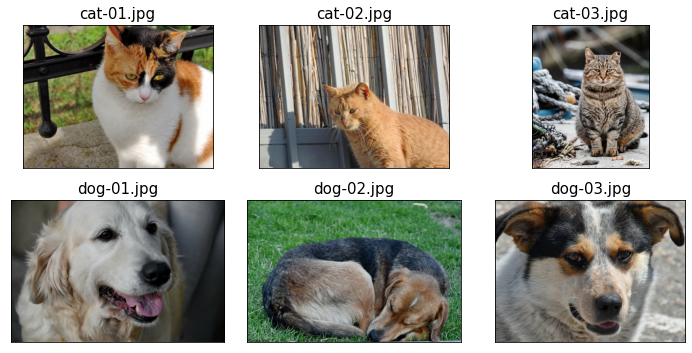

In [112]:
import matplotlib.pyplot as plt
import os

fig = plt.figure(figsize=(10, 5))
for i,file in enumerate(file_list):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    print(f"Image shape - {os.path.basename(file)}: {img.shape}")
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size=15)
    
plt.tight_layout()
plt.show()

Apenas a partir desta visualização e das formas das imagens impressas, já podemos ver que as imagens possuem diferentes proporções. Se você imprimir as proporções (ou formas de matriz de dados) dessas imagens, verá que algumas imagens têm **900 pixels de altura e 1200 pixels de largura (900 × 1200 )**, algumas têm **800 × 1200 e uma tem 900 × 742**. Mais tarde, pré-processaremos essas imagens em um tamanho consistente. Outro ponto a ser considerado é que os rótulos dessas imagens são fornecidos dentro de seus nomes de arquivo. Então, extraímos esses rótulos da lista de nomes de arquivos, atribuindo o **rótulo 1** aos **cães** e o **rótulo 0** aos **gatos**:

In [113]:
labels = [1 if 'dog' in os.path.basename(file) else 0 for file in file_list]
print(labels)

[0, 0, 0, 1, 1, 1]


Agora, temos duas listas: uma lista de nomes de arquivos (ou caminhos de cada imagem) e uma lista de seus rótulos. Anteriormente, aprendemos duas maneiras de criar um conjunto de dados conjunto de dois tensores. Aqui, usaremos a segunda abordagem da seguinte forma:

In [114]:
ds_files_labels = tf.data.Dataset.from_tensor_slices(
    (file_list, labels))

for item in ds_files_labels:
    print(item[0].numpy(), item[1].numpy())

b'cat_dog_images\\cat-01.jpg' 0
b'cat_dog_images\\cat-02.jpg' 0
b'cat_dog_images\\cat-03.jpg' 0
b'cat_dog_images\\dog-01.jpg' 1
b'cat_dog_images\\dog-02.jpg' 1
b'cat_dog_images\\dog-03.jpg' 1


Chamamos esse conjunto de dados de *ds_files_labels*, pois ele possui nomes de arquivos e rótulos. Em seguida, precisamos aplicar transformações a esse conjunto de dados: carregar o conteúdo da imagem de seu caminho de arquivo, decodificar o conteúdo bruto e redimensioná-lo para um tamanho desejado, por exemplo, **80 × 120**. Anteriormente, vimos como aplicar uma função `lambda` usando o método `.map()`. No entanto, como precisamos aplicar várias etapas de pré-processamento desta vez, vamos escrever uma função auxiliar e usá-la ao chamar o método `.map()`:

X: (80, 120, 3) - Y: 0
X: (80, 120, 3) - Y: 0
X: (80, 120, 3) - Y: 0
X: (80, 120, 3) - Y: 1
X: (80, 120, 3) - Y: 1
X: (80, 120, 3) - Y: 1


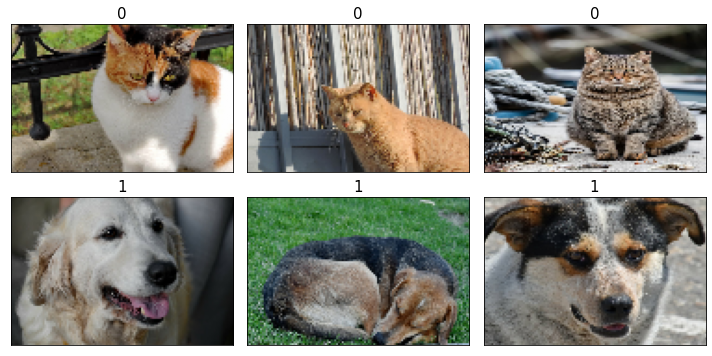

In [115]:
def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image /= 255.0

    return image, label

img_width, img_height = 120, 80

ds_images_labels = ds_files_labels.map(load_and_preprocess)

fig = plt.figure(figsize=(10, 5))
for i,example in enumerate(ds_images_labels):
    print(f"X: {example[0].shape} - Y: {example[1].numpy()}")
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    ax.set_title('{}'.format(example[1].numpy()), 
                 size=15)
    
plt.tight_layout()
plt.show()

A função `load_and_preprocess()` envolve todas as quatro etapas em uma única função, incluindo o carregamento do conteúdo bruto, decodificá-lo e redimensionar as imagens. A função então retorna um conjunto de dados sobre o qual podemos iterar e aplicar outras operações que aprendemos anteriormente.

### Buscando conjuntos de dados disponíveis da biblioteca *tensorflow_datasets*
A biblioteca *tensorflow_datasets* fornece uma boa coleção de conjuntos de dados disponíveis gratuitamente para treinamento ou avaliação de modelos de aprendizado profundo. Os conjuntos de dados são bem formatados e vêm com descrições informativas, incluindo o formato dos recursos e rótulos e seu tipo e dimensionalidade, bem como a citação do artigo original que introduziu o conjunto de dados no formato *BibTeX*. Outra vantagem é que esses conjuntos de dados estão todos preparados e prontos para uso como objetos `tf.data.Dataset`, de modo que todas as funções que abordamos nas seções anteriores podem ser usadas diretamente. Então, vamos ver como usar esses conjuntos de dados em ação.

In [116]:
import tensorflow_datasets as tfds
print(len(tfds.list_builders()))

print("\n",tfds.list_builders()[:5])

310

 ['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset']


O código anterior indica que existem atualmente 278 conjuntos de dados disponíveis (278 conjuntos de dados até o presente momento, mas esse número provavelmente aumentará) — imprimimos os primeiros cinco conjuntos de dados na linha de comando. Existem duas maneiras de buscar um conjunto de dados, que abordaremos nos parágrafos a seguir, buscando dois conjuntos de dados diferentes: *coil100* (`coil100`) e o conjunto de dados de dígitos *MNIST*.

A primeira abordagem consiste em três etapas:
1. Chamando a função do criador de conjunto de dados
2. Executando o método `download_and_prepare()`
3. Chamando o método `as_dataset()`

Vamos trabalhar com a primeira etapa para o conjunto de dados *coil100* e imprimir a descrição associada fornecida na biblioteca:

In [117]:
ds_bldr = tfds.builder('coil100')
print(ds_bldr.info.features)

FeaturesDict({
    'angle': tf.int64,
    'angle_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=72),
    'image': Image(shape=(128, 128, 3), dtype=tf.uint8),
    'object_id': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
})


In [118]:
print(ds_bldr.info.features['image'])

Image(shape=(128, 128, 3), dtype=tf.uint8)


In [119]:
print(ds_bldr.info.citation)

@article{nene1996columbia,
  title={Columbia object image library (coil-20)},
  author={Nene, Sameer A and Nayar, Shree K and Murase, Hiroshi and others},
  year={1996},
  publisher={Technical report CUCS-005-96}
}


Isso fornece algumas informações úteis para entender a estrutura desse conjunto de dados. Os recursos são armazenados como um dicionário com três chaves: `image`, `landmarks`, and `attributes`.

A entrada `image` refere-se à imagem do rosto de uma celebridade; `landmarks` refere-se ao dicionário de pontos faciais extraídos, como a posição dos olhos, nariz e assim por diante; e `attributes` é um dicionário de 40 atributos faciais para a pessoa na imagem, como expressão facial, maquiagem, propriedades do cabelo e assim por diante. Em seguida, chamaremos o método `download_and_prepare()`. Isso fará o *download* dos dados e os armazenará em disco em uma pasta designada para todos os conjuntos de dados do *TensorFlow*. Se você já fez isso uma vez, ele simplesmente verificará se os dados já foram baixados para que não baixe novamente se já existir no local designado:

In [120]:
ds_bldr.download_and_prepare()

In [121]:
# Em seguida, instanciaremos os conjuntos de dados da seguinte forma:

datasets = ds_bldr.as_dataset(shuffle_files=False, split='train', as_supervised=True)
ds_train = next(iter(datasets))[0]


ds_train = datasets.batch(18)
images, labels = next(iter(ds_train))
print(images.shape, labels)

(18, 128, 128, 3) tf.Tensor([ 4 63 20  3 29 11 35 31 69 45 34 58 33 35 44 45 44 68], shape=(18,), dtype=int64)


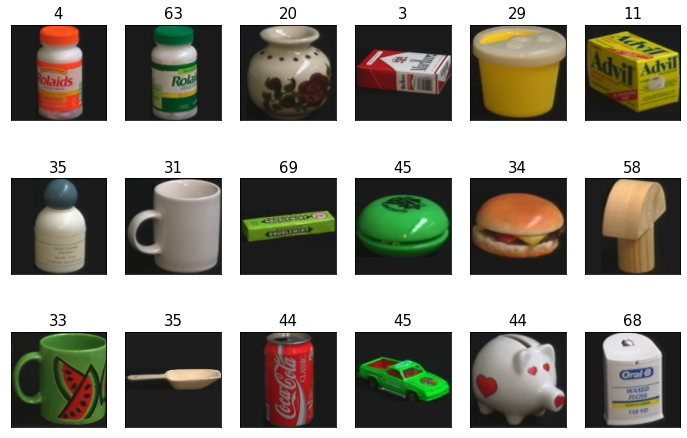

In [122]:
fig = plt.figure(figsize=(12,8))
for i, (image,label) in enumerate(zip(images,labels)):
    ax = fig.add_subplot(3,6,i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image)
    ax.set_title('{}'.format(label), size=15)
plt.show()


Isso era tudo o que precisávamos fazer para buscar e usar o conjunto de dados de imagem *coil100*. Em seguida, prosseguiremos com a segunda abordagem para buscar um conjunto de dados de `tensorflow_datasets`. Existe uma função *wrapper* chamada `load()` que combina as três etapas para buscar um conjunto de dados em uma. Vamos ver como ele pode ser usado para buscar o conjunto de dados de dígitos MNIST:

In [123]:
mnist, mnist_info = tfds.load('mnist', with_info=True, shuffle_files=False)
print(mnist_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\willi\\tensorflow_datasets\\mnist\\3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


Como podemos ver, o conjunto de dados *MNIST* é dividido em duas partições. Agora, podemos pegar a partição *train*, aplicar uma transformação para converter os elementos de um dicionário em uma tupla e visualizar 10 exemplos:

In [124]:
ds_train = mnist['train']
ds_train = ds_train.map(lambda item: (item['image'], item['label']))
ds_train = ds_train.batch(10)
batch = next(iter(ds_train))
print(batch[0].shape, batch[1])

(10, 28, 28, 1) tf.Tensor([4 1 0 7 8 1 2 7 1 6], shape=(10,), dtype=int64)


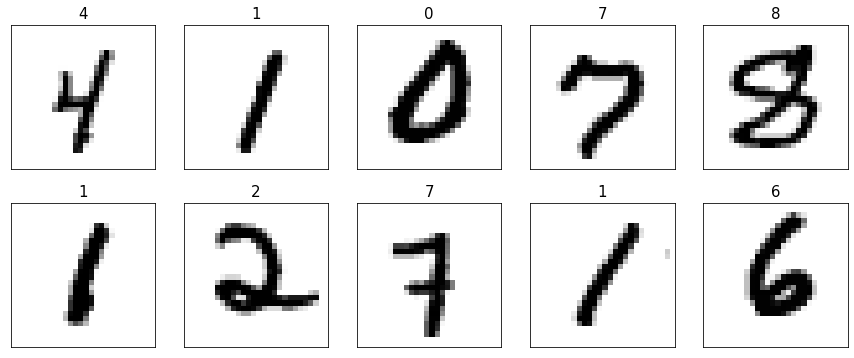

In [125]:
fig = plt.figure(figsize=(15, 6))
for i,(image,label) in enumerate(zip(batch[0], batch[1])):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image[:, :, 0], cmap='gray_r')
    ax.set_title('{}'.format(label), size=15)
plt.show()


Isso conclui nossa cobertura de construção e manipulação de conjuntos de dados e busca de conjuntos de dados da biblioteca `tensorflow_datasets`. A seguir, veremos como construir modelos RN no *TensorFlow*.

### Como criar um modelo de Rede Neural no *TensorFlow*
Até agora, você aprendeu sobre os componentes utilitários básicos do *TensorFlow* para manipular tensores e organizar dados em formatos que podemos iterar durante o treinamento. Nesta seção, finalmente implementaremos nosso primeiro modelo preditivo no *TensorFlow*. Como o *TensorFlow* é um pouco mais flexível, mas também mais complexo do que as bibliotecas de aprendizado de máquina, como *scikit-learn*, começaremos com um modelo de regressão linear simples.

### A API *TensorFlow* Keras (`tf.keras`)

Keras é uma API NN de alto nível e foi originalmente desenvolvida para ser executada em cima de outras bibliotecas, como *TensorFlow* e *Theano*. *Keras* fornece uma interface de programação modular e amigável que permite a prototipagem fácil e a construção de modelos complexos em apenas algumas linhas de código. O *Keras* pode ser instalado independentemente do *PyPI* e configurado para usar o *TensorFlow* como seu mecanismo de *backend.* O *Keras* está totalmente integrado ao *TensorFlow* e seus módulos podem ser acessados ​​por meio do `tf.keras`.

No *TensorFlow* 2.0, o `tf.keras` se tornou a abordagem principal e recomendada para implementar modelos. Isso tem a vantagem de oferecer suporte a funcionalidades específicas do *TensorFlow*, como *pipelines* de conjunto de dados usando `tf.data`. Usaremos o módulo `tf.keras` para construir modelos de rede neural.

Como você verá nas subseções a seguir, a API *Keras* (`tf.keras`) torna a construção de um modelo de Rede Neural extremamente fácil. A abordagem mais usada para construir uma RN no *TensorFlow* é por meio de `tf.keras.Sequential()`, que permite empilhar camadas para formar uma rede. Uma pilha de camadas pode ser fornecida em uma lista Python para um modelo definido como `tf.keras`.Sequential(). Alternativamente, as camadas podem ser adicionadas uma a uma usando o método `.add()`.
Além disso, `tf.keras` nos permite definir um modelo subclassificando `tf.keras`.Model. Isso nos dá mais controle sobre a passagem direta definindo o método `call()` para nossa classe de modelo para especificar a passagem direta explicitamente. Veremos exemplos de ambas as abordagens para construir um modelo de RN usando a API `tf.keras`.
Finalmente, como você verá nas subseções a seguir, os modelos construídos usando a API `tf.keras` podem ser compilados e treinados por meio dos métodos `.compile()` e `.fit()`.

### Construindo um modelo de regressão linear
Construiremos um modelo simples para resolver um problema de regressão linear. Primeiro, vamos criar um conjunto de dados fictício no *NumPy* e visualizá-lo:

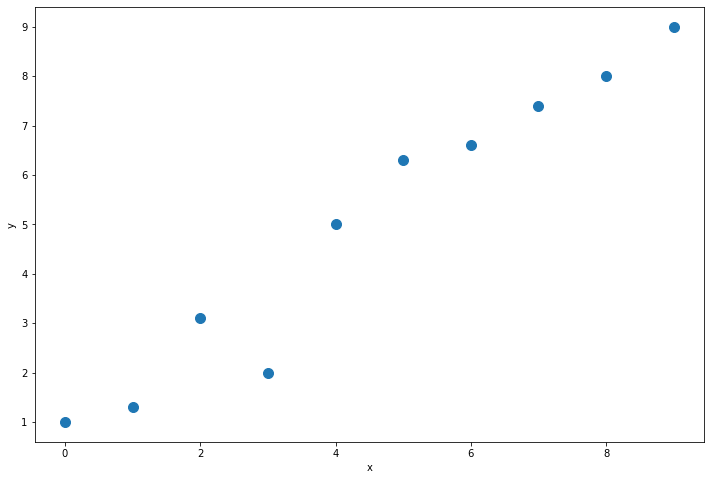

In [126]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3,
                    6.6, 7.4, 8.0,
                    9.0])

plt.figure(figsize=(12,8))
plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Em seguida, padronizaremos os recursos (centralização média e divisão pelo desvio padrão) e criaremos um conjunto de dados do *TensorFlow*:

In [127]:
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)

ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32),
     tf.cast(y_train, tf.float32)))

Agora, podemos definir nosso modelo para regressão linear como $\small z = wx + b$ . Aqui, nós iremos usar a API *Keras* `tf.keras` que fornece camadas predefinidas para construir modelos de RN complexos, mas para começar, você aprenderá como definir um modelo do zero. Mais adiante, você verá como usar essas camadas predefinidas.

Para este problema de regressão, definiremos uma nova classe derivada da classe `tf.keras.Model`. A subclassificação de `tf.keras.Model` nos permite usar as ferramentas *Keras* para explorar o modelo, o treinamento e a avaliação. No construtor de nossa classe, definiremos os parâmetros do nosso modelo, $\small w$ e $\small b$, que correspondem aos parâmetros de peso e de polarização, respectivamente. Por fim, definiremos o método `call()` para determinar como esse modelo usa os dados de entrada para gerar sua saída:

In [128]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w*x + self.b

Em seguida, instanciaremos um novo modelo da classe `MyModel()` que podemos treinar com base nos dados de treinamento. A API *TensorFlow Keras* fornece um método chamado `.summary()` para modelos instanciados do `tf.keras.Model`, que nos permite obter um resumo dos componentes do modelo camada por camada e o número de parâmetros em cada camada. Como subclassificamos nosso modelo de `tf.keras.Model`, o método `.summary()` também está disponível para nós. Mas, para poder chamar `model.summary()`, primeiro precisamos especificar a **dimensionalidade da entrada** (o número de recursos) para este modelo. Podemos fazer isso chamando `model.build()` com a forma esperada dos dados de entrada:

In [129]:
model = MyModel()

model.build(input_shape=(None, 1))
model.summary()

Model: "my_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Observe que usamos `None` como um espaço reservado para a primeira dimensão do tensor de entrada esperado via `model.build()`, que nos permite usar um tamanho de **lote arbitrário**. No entanto, o número de recursos é fixo (no caso aqui é **1**), pois corresponde diretamente ao número de parâmetros de peso do modelo. Construir camadas de modelo e parâmetros após a instanciação chamando o método `.build()` é chamado de **criação de variável tardia**. Para este modelo simples, já criamos os parâmetros do modelo no construtor; portanto, especificar `input_shape` via `build()` não tem mais efeito em nossos parâmetros, mas ainda é necessário se quisermos chamar `model.summary()`.

Depois de definir o modelo, podemos definir a função de custo que queremos minimizar para encontrar os pesos ótimos do modelo. Aqui, escolheremos o **erro quadrático médio (MSE)** como nossa função de custo. Além disso, para aprender os parâmetros de peso do modelo, usaremos o *Gradient Descendent* estocástico (SGD). E implementaremos esse treinamento por meio do procedimento do SGD por nós mesmos, usaremos os métodos *Keras* `compile()` e `fit()` para fazer a mesma coisa.

Para implementar o algoritmo SGD, precisamos calcular os gradientes. Em vez de calcular manualmente os gradientes, usaremos a *API* do *TensorFlow* `tf.GradientTape`.

In [130]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


## testing the function:
yt = tf.convert_to_tensor([1.0])
yp = tf.convert_to_tensor([1.5])

loss_fn(yt, yp)

<tf.Tensor: shape=(), dtype=float32, numpy=0.25>

In [131]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

Agora, podemos definir os hiperparâmetros e treinar o modelo por **200 épocas**. Criaremos uma versão em lote do conjunto de dados e repetiremos o conjunto de dados com `count=None`, o que resultará em um conjunto de dados infinitamente repetido:

In [132]:
tf.random.set_seed(1)

num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))


ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(1)

Ws, bs = [], []

for i, batch in enumerate(ds_train):
    if i >= steps_per_epoch * num_epochs:
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by)

    train(model, bx, by, learning_rate=learning_rate)
    if i%log_steps==0:
        print('Epoch {:4d} Step {:2d} Loss {:6.4f}'.format(
              int(i/steps_per_epoch), i, loss_val))

Epoch    0 Step  0 Loss 43.5600
Epoch   10 Step 100 Loss 0.7530
Epoch   20 Step 200 Loss 20.1759
Epoch   30 Step 300 Loss 23.3976
Epoch   40 Step 400 Loss 6.3481
Epoch   50 Step 500 Loss 4.6356
Epoch   60 Step 600 Loss 0.2411
Epoch   70 Step 700 Loss 0.2036
Epoch   80 Step 800 Loss 3.8177
Epoch   90 Step 900 Loss 0.9416
Epoch  100 Step 1000 Loss 0.7035
Epoch  110 Step 1100 Loss 0.0348
Epoch  120 Step 1200 Loss 0.5404
Epoch  130 Step 1300 Loss 0.1170
Epoch  140 Step 1400 Loss 0.1195
Epoch  150 Step 1500 Loss 0.0944
Epoch  160 Step 1600 Loss 0.4670
Epoch  170 Step 1700 Loss 2.0695
Epoch  180 Step 1800 Loss 0.0020
Epoch  190 Step 1900 Loss 0.3612


Vamos olhar para o modelo treinado e plotá-lo. Para dados de teste, criaremos uma matriz *NumPy* de valores espaçados uniformemente entre 0 e 9. Como treinamos nosso modelo com recursos padronizados, também aplicaremos a mesma padronização aos dados de teste:

Final Parameters: 2.6576622 4.8798566


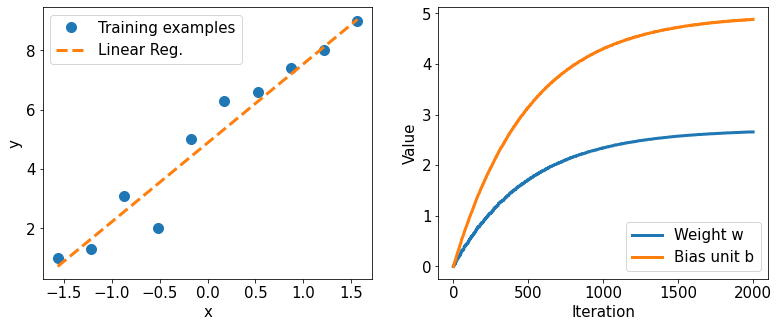

In [133]:
print('Final Parameters:', model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

A figura acima mostra o gráfico de dispersão dos exemplos de treinamento e o modelo de regressão linear treinado, bem como o histórico de convergência do peso, $\small w$, e a unidade de polarização, $\small b$.

### Treinamento de modelos por meio dos métodos `.compile()` e `.fit()`

No exemplo anterior, vimos como treinar um modelo escrevendo uma função personalizada, `train()`, aplicamos a otimização SGD. No entanto, escrever a função `train()` pode ser uma tarefa repetitiva em diferentes projetos. A API *TensorFlow Keras* fornece um método `.fit()` conveniente que pode ser chamado em um modelo instanciado. Para mostrar como isso funciona, vamos criar um novo modelo e compilá-lo selecionando o otimizador, a função de perda e as métricas de avaliação:

In [134]:
tf.random.set_seed(1)
model = MyModel()
model.compile(optimizer='sgd', 
              loss=loss_fn,
              metrics=['mae', 'mse'])

Agora, podemos simplesmente chamar o método `fit()` para treinar o modelo. Podemos passar um conjunto de dados em lote (como *ds_train*, que foi criado no exemplo anterior). No entanto, desta vez você verá que podemos passar os arrays *NumPy* para $\small x$ e $\small y$ diretamente, sem a necessidade de criar um dataset:

In [135]:
model.fit(X_train_norm, y_train, 
          epochs=num_epochs, batch_size=batch_size,
          verbose=1)

Epoch 1/200
10/10 [==============================] - 0s 666us/step - loss: 27.8723 - mae: 4.5654 - mse: 27.8723
Epoch 2/200
10/10 [==============================] - 0s 667us/step - loss: 18.6586 - mae: 3.7446 - mse: 18.6586
Epoch 3/200
10/10 [==============================] - 0s 667us/step - loss: 12.5239 - mae: 3.0454 - mse: 12.5239
Epoch 4/200
10/10 [==============================] - 0s 555us/step - loss: 8.4670 - mae: 2.4907 - mse: 8.4670
Epoch 5/200
10/10 [==============================] - 0s 666us/step - loss: 5.7632 - mae: 2.0567 - mse: 5.7632
Epoch 6/200
10/10 [==============================] - 0s 556us/step - loss: 3.9697 - mae: 1.7232 - mse: 3.9697
Epoch 7/200
10/10 [==============================] - 0s 555us/step - loss: 2.7766 - mae: 1.4752 - mse: 2.7766
Epoch 8/200
10/10 [==============================] - 0s 778us/step - loss: 1.9861 - mae: 1.2578 - mse: 1.9861
Epoch 9/200
10/10 [==============================] - 0s 778us/step - loss: 1.4572 - mae: 1.0978 - mse: 1.4572
Epoc

Depois que o modelo for treinado, visualize os resultados e verifique se eles são semelhantes aos resultados do método anterior.

2.7067394 4.9657216


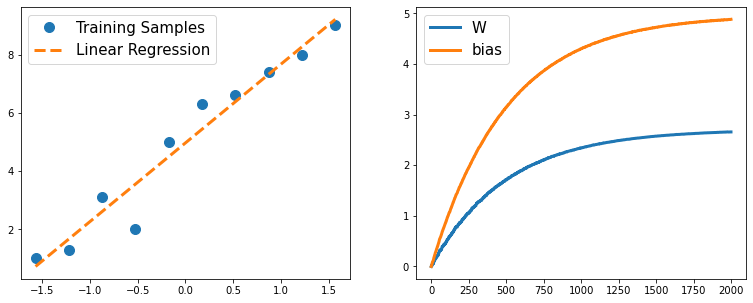

In [136]:
print(model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training Samples', 'Linear Regression'], fontsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['W', 'bias'], fontsize=15)
plt.show()

### Construindo um perceptron multicamada para classificar flores no conjunto de dados *Iris*

No exemplo anterior, você viu como construir um modelo do zero. Treinamos esse modelo usando otimização do SGD. Embora tenhamos iniciado nossa jornada com base no exemplo mais simples possível, você pode ver que definir o modelo do zero, mesmo para um caso tão simples, não é atraente nem uma boa prática. Em vez disso, o *TensorFlow* fornece camadas já definidas por meio de `tf.keras.layers` que podem ser prontamente usadas como blocos de construção de um modelo de Rede Neural.

Nesta seção, você aprenderá como usar essas camadas para resolver uma tarefa de classificação usando o conjunto de dados *Iris* flower e construir um *perceptron* de duas camadas usando a API *Keras*. Primeiro, vamos obter os dados de `tensorflow_datasets`:

In [137]:
iris, iris_info = tfds.load('iris', with_info=True)
print(iris_info)

tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.0.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_path='C:\\Users\\willi\\tensorflow_datasets\\iris\\2.0.0',
    download_size=4.44 KiB,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('features', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_

Imprimimos algumas informações sobre este conjunto de dados. No entanto, você notará nas informações mostradas que esse conjunto de dados vem com apenas uma partição, portanto, temos que dividir o conjunto de dados em partições de **treinamento** e **teste** (e validação para a prática adequada de aprendizado de máquina) por conta própria. Vamos supor que queremos usar dois terços do conjunto de dados para treinamento e manter os exemplos restantes para teste. A biblioteca `tensorflow_datasets` fornece uma ferramenta conveniente que nos permite determinar fatias e divisões por meio do objeto `DatasetBuilder` antes de carregar um conjunto de dados. Você pode saber mais sobre divisões em https://www.tensorflow.org/datasets/splits.

Uma abordagem alternativa é carregar primeiro todo o conjunto de dados e depois usar `.take()` e `.skip()` para dividir o conjunto de dados em duas partições. Se o conjunto de dados não for embaralhado no início, também podemos embaralhar o conjunto de dados. No entanto, precisamos ter muito cuidado com isso, pois pode levar à mistura de exemplos de treinamento/teste, o que não é aceitável em aprendizado de máquina. Para evitar isso, temos que definir um argumento, `reshuffle_each_iteration=False`, no método `.shuffle()`. O código para dividir o conjunto de dados em treinar/teste é o seguinte:

In [138]:
tf.random.set_seed(1)
ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)
ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

## checking the number of examples:

n = 0
for example in ds_train_orig:
    n += 1
print(n)


n = 0
for example in ds_test:
    n += 1
print(n)

100
50


Em seguida, como você já viu nas seções anteriores, precisamos aplicar uma transformação através do método `.map()` para converter o dicionário em uma tupla:

In [139]:
ds_train_orig = ds_train_orig.map(lambda x: (x['features'], x['label']))
ds_test = ds_test.map(lambda x: (x['features'], x['label']))

Agora, estamos prontos para usar a *API Keras* para construir um modelo com eficiência. Em particular, usando a classe `tf.keras.Sequential`, podemos empilhar algumas camadas *Keras* e construir uma RN. Você pode ver a lista de todas as camadas Keras que já estão disponíveis em https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers.

Para este problema, vamos usar a camada Densa (`tf.keras.layers.Dense`), que também é conhecida como camada totalmente conectada (FC) ou camada linear, pode ser melhor representada por $\small f(w \times x+b)$ , onde $\small x$ são os recursos de entrada, $\small w$ e $\small b$ são a matriz de pesos e o vetor de polarização, e $\small f$ é a função de ativação.

Se você pensar nas camadas em uma RN, cada camada recebe suas entradas da camada anterior; portanto, sua dimensionalidade (classificação e forma) é fixa. Normalmente, precisamos nos preocupar com a dimensionalidade da saída apenas quando projetamos uma arquitetura RN. (Observação: a primeira camada é a exceção, mas o *TensorFlow/Keras* nos permite decidir a dimensionalidade de entrada da primeira camada após definir o modelo por meio da criação de variáveis ​​tardias. Aqui, queremos definir um modelo com duas camadas ocultas. O primeiro recebe uma entrada com quatro características e as projeta para 16 neurônios. A segunda camada recebe a saída da camada anterior (que tem tamanho 16) e as projeta para três neurônios de saída, pois temos três rótulos de classe. Isso pode ser feito usando a classe `Sequential` e a camada `Dense` no *Keras* da seguinte forma:

In [140]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', 
                          name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')])

iris_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


Observe que determinamos a forma de entrada para a primeira camada via `input_shape=(4,)` e, portanto, não precisamos mais chamar `.build()` para usar `iris_model.summary()`.

O resumo do modelo impresso indica que a primeira camada (**fc1**) possui 80 parâmetros e a segunda camada possui 51 parâmetros. Você pode verificar isso por $^{(n_{in} + 1)\times n_{out}}$, onde $n_{in}$ é o número de unidades de entrada e $n_{out}$ o número de unidades de saída. Lembre-se de que para uma camada totalmente (densamente) conectada, os parâmetros apreensíveis são a matriz de peso de tamanho $n_{in} \times n_{out}$ e o vetor de viés de tamanho $n_{out}$ . Além disso, observe que usamos a função de ativação sigmóide para a primeira camada e ativação softmax para a última camada (saída). A ativação do Softmax na última camada é usada para suportar **a classificação multiclasse**, pois aqui temos três rótulos de classe (e é por isso que temos três neurônios na camada de saída). Discutiremos as diferentes funções de ativação e suas aplicações mais adiante.

Em seguida, compilaremos este modelo para especificar a função de perda, o otimizador e as métricas para avaliação:

In [141]:
iris_model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

Agora podemos treinar o modelo. Especificaremos o número de épocas como 100 e o tamanho do lote como 2. No código a seguir, construiremos um conjunto de dados de repetição **infinita**, que será passado para o método `fit()` para treinar o modelo. Nesse caso, para que o método `fit()` possa acompanhar as épocas, ele precisa saber o número de etapas para cada época.

Dado o tamanho dos nossos dados de treinamento (no caso será 100) e o tamanho do lote (`batch_size`), podemos determinar o número de etapas em cada época, `steps_per_epoch`:

In [142]:
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)


history = iris_model.fit(ds_train, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, 
                         verbose=0)

O histórico da variável retornada mantém a perda de treinamento e a precisão do treinamento (já que foram especificadas como métricas para `iris_model.compile()`) após cada época. Podemos usar isso para visualizar as curvas de aprendizado da seguinte forma:

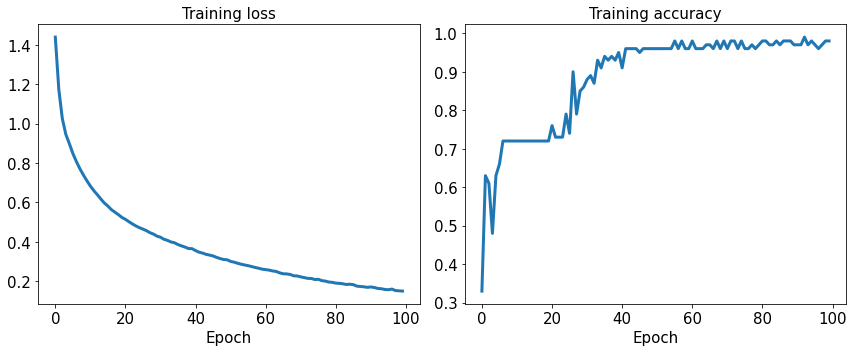

In [ ]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

### Avaliando o modelo treinado no conjunto de dados de teste
Como especificamos *'accuracy'* como nossa métrica de avaliação em `iris_model.compile()`, agora podemos avaliar diretamente o modelo no conjunto de dados de teste:

In [ ]:
results = iris_model.evaluate(ds_test.batch(50), verbose=0)
print(f'Test loss: {results[0]:.4f} - Test Acc.: {results[1]:.4f}')

Test loss: 0.1483 - Test Acc.: 0.9800


Observe que também precisamos agrupar o conjunto de dados de teste para garantir que a entrada do modelo tenha a dimensão correta (classificação). Como discutimos anteriormente, chamar `.batch()` aumentará a classificação dos tensores recuperados em 1. Os dados de entrada para `.evaluate()` devem ter uma dimensão designada para o lote, embora aqui (para avaliação), o tamanho do lote não importa. Portanto, se passarmos `ds_batch.batch(50)` para o método `.evaluate()`, todo o conjunto de dados de teste será processado em um lote de tamanho 50, mas se passarmos `ds_batch.batch(1)`, 50 lotes de tamanho 1 serão processados.

### Salvando e recarregando o modelo treinado

Modelos treinados podem ser salvos em disco para uso futuro. Isso pode ser feito da seguinte forma:

In [ ]:
iris_model.save('iris_classifier.h5',  # Nome do Arquivo
                    overwrite= True,
                    include_optimizer= True,
                    save_format = 'h5')

A primeira opção é o nome do arquivo. Chamar `iris_model.save()` salvará a arquitetura do modelo e todos os parâmetros aprendidos. No entanto, se você deseja salvar apenas a arquitetura, pode usar o método `iris_model.to_json()`, que salva a configuração do modelo no formato **JSON**. Ou se você quiser salvar apenas os pesos do modelo, você pode fazer isso chamando `iris_model.save_weights()`. O `save_format` pode ser especificado como *'h5'* para o formato *HDF5* ou *'tf'* para o formato *TensorFlow*.

Agora, vamos recarregar o modelo salvo. Como salvamos a arquitetura do modelo e os pesos, podemos reconstruir e recarregar facilmente os parâmetros em apenas uma linha:

In [ ]:
iris_model_new = tf.keras.models.load_model('iris_classifier.h5')

# Verificando a arquitetura do modelo
iris_model_new.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Vimos que é a mesma arquitetura do iris_model
# Vamos avaliar o novo modelo recarregado no conjunto de dados teste para verificar se o resultado é mesmo:

results = iris_model_new.evaluate(ds_test.batch(33), verbose=0)
print(f'Test loss: {results[0]:.4f} - Test Acc.: {results[1]:.4f}')


Test loss: 0.1483 - Test Acc.: 0.9800


### Escolhendo funções de ativação para redes neurais multicamadas

Para simplificar, nós discutimos apenas a função de ativação sigmóide no contexto de Redes Neurais *feedforward* multicamadas até agora; nós a usamos na camada oculta, bem como na camada de saída na implementação do MLP.

Observe que a função logística sigmoidal, $\small \sigma(z) = \dfrac{1}{1 + e^{-z}}$, é referida como a função sigmóide para brevidade, que é comum na literatura de aprendizado de máquina. A seguir, você aprenderá mais sobre funções não lineares alternativas que são úteis para implementar Redes Neurais multicamadas.

Tecnicamente, podemos usar qualquer função como função de ativação em Redes Neurais multicamadas, desde que seja diferenciável. Podemos até usar funções de ativação linear, como a Adaline. No entanto, na prática, não seria muito útil usar funções de ativação linear para ambas as camadas ocultas e de saída, pois queremos introduzir não linearidade em uma Rede Neural Artificial típica para poder resolver problemas complexos. A soma de funções lineares produz uma função linear, afinal.

A função de ativação logística (sigmóide), já conhecida, provavelmente imita o conceito de um neurônio em um cérebro — podemos pensar nela como a probabilidade de um neurônio disparar. No entanto, a função de ativação logística (sigmóide) pode ser problemática se tivermos uma entrada altamente negativa, pois a saída da função sigmóide será próxima de zero neste caso. Se a função sigmóide retornar uma saída próxima de zero, a Rede Neural aprenderá muito lentamente e será mais provável que fique preso nos mínimos locais durante o treinamento. É por isso que as pessoas geralmente preferem uma tangente hiperbólica como função de ativação em camadas ocultas.

Antes de discutirmos como é uma tangente hiperbólica, vamos recapitular brevemente alguns dos fundamentos da função logística e examinar uma generalização que a torna mais útil para problemas de classificação multirrótulo.